# Lesson 20: BVPs - shooting methods
The goal of this lesson is to introduce/reintroduce some ideas about differential equations and boundary value problems and some python routines that can be used to analyze models with BVPs.

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fsolve
from scipy.integrate import solve_ivp
%matplotlib inline

### Example 1
Consider the boundary value problem

$$-u'' + \pi^2 u = 2\pi^2 \sin(\pi x), u(0)=u(1)=0.$$

Since we have boundary conditions that specify the value of $u$ at the boundaries, we say they are Dirichlet boundary conditions. Note from the BVP theory we spoke about before Spring Break, this system has a unique solution.

We can solve this problem numerically by discretizing the space between $x=0$ and $x=1$ and using numerical approximations of $u''$ at each point.
Let's break up space into $n$ segments so $x_0 = 0$, $x_n = 1$, and $x_i = 0 + hi$.

Then at an interior point $x_i$ (not 0 or $n$) we have that $u_i'' = \frac{u_{i-1} -2 u_i + u_{i+1}}{h^2} + \mathcal{O}(h^2)$.

If we drop the error term in the derivative approximation, we can write our DE with the boundary conditions as the discrete system below.

\begin{align*}
u_0 & = 0 \\
\frac{-u_{i-1} +2 u_i - u_{i+1}}{h^2} + \pi^2 u_i &= 2 \pi^2 \sin(\pi x_i) \\
u_n & = 0\end{align*}

The equations associated with interior points can be rewritten as

$$-u_{i-1} + (2+h^2\pi^2) u_i - u_{i+1} = 2 h^2\pi^2 \sin(\pi x_i).$$



Then if we let $\vec{u} = \begin{bmatrix}u_0 \\ u_1 \\ ... \\ u_i \\ ... \\ u_n\end{bmatrix}$, we can write this system in matrix vector form $A\vec{u} = \vec{b}$.

$$ \begin{bmatrix}1 & 0 & & & & & \\-1 & (2+h^2\pi^2) & -1 & & & & \\ 0 & -1 & (2+h^2\pi^2) & -1 & & & \\  &  .  & . & . & & & \\ & & & &-1 & (2+h^2\pi^2) & -1 \\ & & & & & 0 & 1 \end{bmatrix} \begin{bmatrix}u_0 \\ u_1 \\ ... \\ u_i \\ ... \\ u_n\end{bmatrix} = \begin{bmatrix}0 \\ 2 h^2\pi^2 \sin(\pi x_1) \\ ... \\ 2 h^2\pi^2 \sin(\pi x_i) \\ ... \\ 0 \end{bmatrix}
$$

[[0.00000000e+00 1.27182109e-03 2.41914747e-03 3.32967084e-03
  3.91426283e-03 4.11569950e-03 3.91426283e-03 3.32967084e-03
  2.41914747e-03 1.27182109e-03 1.22464680e-16]]
0.004115699496889835


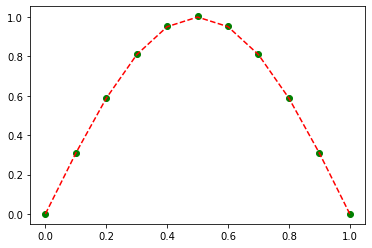

In [3]:
n = 10 #number of segments
x = np.linspace(0,1,n+1) #n+1 equally spaced points between 0 and 1
h = (1.-0.)/n #step size
A = np.zeros((n+1,n+1))  #zero matrix with shape n+1 by n+1
b = np.zeros((n+1,1)) #RHS vector

#Boundary Conditions
A[0,0] = 1.  #update first row
b[0] = 0.

A[n,n] = 1.  #update last row
b[n] = 0.

#interior points
for i in range(1,n):
    A[i,i-1] = -1.
    A[i,i] = 2. + h**2*np.pi**2
    A[i,i+1] = -1.
    b[i] = 2.*h**2*np.pi**2*np.sin(np.pi*x[i])

u = np.linalg.solve(A,b)

#compare with exact
uexact = np.sin(np.pi*x)
errors = np.abs(uexact - u.T)
print(errors)
print(np.max(errors))

plt.plot(x,u,'go',x,uexact,'r--');







## Shooting method approach to above problem
The finite difference approach to the above problem isn't the only way to solve it. We can also use a shooting approach where we replace the BVP with an IVP involving an unknown parameter. We then 'tune' that parameter using the second boundary condition.

Replace the BVP

$$-u'' + \pi^2 u = 2\pi^2 \sin(\pi x), u(0)=u(1)=0$$

with the IVP

$$-u'' + \pi^2 u = 2\pi^2 \sin(\pi x), u(0)=0, u'(0)=\alpha.$$

Now we need to find the right value of $\alpha$ so that $u(1)=0$. We can use equation solving routines to help us with that. 



C:\Users\skorczewskit\Anaconda3\lib\site-packages\scipy\integrate\_ivp\base.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  y0 = np.asarray(y0)
C:\Users\skorczewskit\Anaconda3\lib\site-packages\numpy\core\shape_base.py:121: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


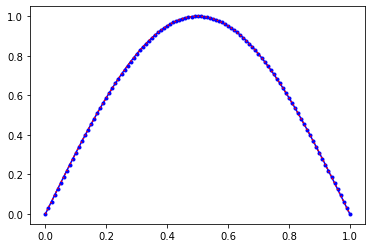

In [11]:
def sysde(x,vec):
    u,z = vec[0],vec[1]
    dudx = z
    dzdx = np.pi**2*u - 2.*np.pi**2*np.sin(np.pi*x)
    return([dudx,dzdx])

#need a function that takes in alpha and returns u(1)
def getuone(alpha):
    sol = solve_ivp(sysde,[0.,1.],[0.,alpha],dense_output=True)
    uone = sol.sol(1)[0]
    return(uone)  

#use fsolve to find a root
alpha_opt = fsolve(getuone,1.)

#now solve ivp again using correct alpha
sol = solve_ivp(sysde,[0.,1.],[0.,alpha_opt],dense_output=True)

xs = np.linspace(0.,1.,101)
us = sol.sol(xs)[0]

uexact = np.sin(np.pi*xs)
plt.plot(xs,us,'b.-',xs,uexact,'r:');

### Mortar example
From Newton's Second Law we have the following system of equations that describe the motion of a mortar shell under the influence of gravity and air resistance:

$$\begin{bmatrix}x''\\y''\end{bmatrix} = \begin{bmatrix}0\\-g\end{bmatrix} - \alpha \sqrt{x'^2 + y'^2} \begin{bmatrix}x'\\y'\end{bmatrix}.$$

We can rewrite these two coupled second order differential equations as a coupled system of four first order equations:

$$\begin{bmatrix}x'\\y'\\xv'\\yv'\end{bmatrix} = \begin{bmatrix}xv\\yv\\-\alpha \sqrt{xv^2 + yv^2} xv \\-g -\alpha \sqrt{xv^2 + yv^2} yv\end{bmatrix},$$

where $xv,yv$ represent the velocities in the $x,y$ directions, respectively.

Here we let $\alpha = 0.001$ be a coefficient for drag that accounts for air denisty, shape, and mass. If we further assume the mortar launches at 100 m/s, the initial conditions that complete the initial value problem are 

$$\begin{bmatrix}x\\y\\xv\\yv\end{bmatrix}(0) = \begin{bmatrix}0\\0\\100\cos(\theta)\\100\sin(\theta)\end{bmatrix}.$$

Our task is to find the launch angle, $\theta$, that allows us to hit a target 500 meters away.

[48.19053225]


C:\Users\skorczewskit\Anaconda3\lib\site-packages\scipy\integrate\_ivp\base.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  y0 = np.asarray(y0)
C:\Users\skorczewskit\Anaconda3\lib\site-packages\numpy\core\shape_base.py:121: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


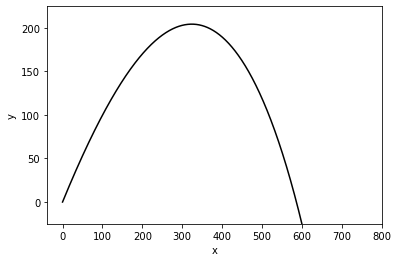

In [29]:
#mortar example
def model(t,y):
    g = -9.8
    #y[0] = x
    #y[1] = y
    #y[2] = x'
    #y[3] = y'
    xp, yp, xv, yv = y[0],y[1],y[2],y[3]
    dydt = np.array([xv, yv, -0.001*xv*np.sqrt(xv**2 + yv**2), g - 0.001*yv*np.sqrt(xv**2 + yv**2)])
    return dydt

#init conditions v=100 mph  theta=25 degrees
def gety500(theta):  #function that takes in theta and returns y when x=142 m
    sol = solve_ivp(model,[0.,20],[0.,0.,100*np.cos(theta),100.*np.sin(theta)],dense_output=True)
    def func(t):
        return(sol.sol(t)[0]-600)
    tstar = fsolve(func,15)  # get time when x = 500
    y500 = sol.sol(tstar)[1] #y value when x = 500
    return(y500+25)

theta_opt = fsolve(gety500,np.pi/4.) #solve for optimal theta to hit target

sol = solve_ivp(model,[0.,20],[0.,0.,100*np.cos(theta_opt),100.*np.sin(theta_opt)],dense_output=True)

ts = np.linspace(0,20,1001)
xs = sol.sol(ts)[0]
ys = sol.sol(ts)[1]

plt.plot(xs,ys,'k');
plt.xlabel('x');
plt.ylabel('y');
plt.ylim(-25,1.1*max(ys));

print(theta_opt*180./np.pi)





    

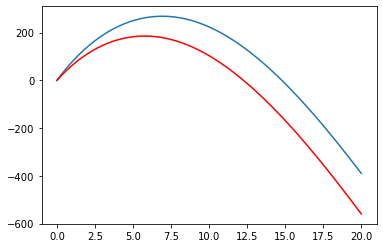

In [18]:
theta = np.pi/3.
sol = solve_ivp(model,[0.,100],[0.,0.,100*np.cos(theta),100.*np.sin(theta)],dense_output=True)
ts = np.linspace(0,20,1001)
plt.plot(ts,sol.sol(ts)[1])

theta = np.pi/4.
sol = solve_ivp(model,[0.,100],[0.,0.,100*np.cos(theta),100.*np.sin(theta)],dense_output=True)
ts = np.linspace(0,20,1001)
plt.plot(ts,sol.sol(ts)[1],'r')